In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')
%matplotlib inline

In [2]:
app = pd.read_pickle('app_cleaned.pickle')

In [3]:
app = app.drop_duplicates()

In [4]:
app = app.dropna(axis = 0)#remove the NAN

In [5]:
app.head()

,category,current_rating,description,id,is_InAppPurcased,is_multilingual,is_multiplatform,name,new_version_desc,num_current_rating,...,review2,review2_star,review3,review3_star,scrape_date,seller,size,update_date,url,version
0,Finance,1.80000,The JPay App lets you send money and email to ...,584959322,0,0,0,JPay,This update has a big new feature for the new ...,20.0,...,What is wrong with this freakin App? It keep s...,1.0,Emails are not sent and received in a timely m...,1.0,2017-03-13,"JPay, Inc.",13.0 MB,"Jan 20, 2017",https://itunes.apple.com/us/app/jpay/id5849593...,4.7
2,Finance,4.64497,Access your interactive Experian Credit Report...,1087101090,1,0,0,Experian - Free Credit Report,Bug fixes and other minor updates,169.0,...,This Experian app helps me measure my credit a...,5.0,I don't exactly like credit bureaus my experie...,5.0,2017-03-13,"CONSUMERINFO.COM, INC.",58.0 MB,"Feb 22, 2017",https://itunes.apple.com/us/app/experian-free-...,1.6.1
3,Finance,2.16667,Use the Vanguard app to check your accounts an...,335186209,0,0,0,Vanguard,See what's new! Have an IRA? Watch your progr...,30.0,...,The app is very easy to use and has tons of he...,5.0,My company used to use Fidelity for our retire...,1.0,2017-03-13,"The Vanguard Group, Inc.",49.0 MB,"Jan 22, 2017",https://itunes.apple.com/us/app/vanguard/id335...,7.1
4,Finance,4.60773,Conveniently manage your credit card account f...,1128712763,0,0,0,Credit One Bank Mobile,- Ability add an additional account if qualifi...,724.0,...,I am so fed up with this entire company! I'm g...,2.0,"I have no complaints, well one but its not a b...",5.0,2017-03-13,"Credit One Bank, National Association",42.8 MB,"Jan 31, 2017",https://itunes.apple.com/us/app/credit-one-ban...,1.4
5,Finance,4.34066,Be the first to know about news and market mov...,552799694,1,0,0,Seeking Alpha Portfolio,Performance improvements,91.0,...,SA offers a lot of information supplied by art...,5.0,I'm new to learning about stocks and managing ...,5.0,2017-03-13,Seeking Alpha Ltd.,46.2 MB,"Feb 14, 2017",https://itunes.apple.com/us/app/seeking-alpha-...,3.3.7


In [8]:
ratio = app['num_current_rating']/app['num_overall_rating']

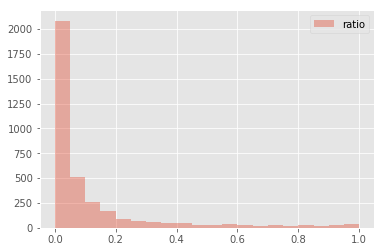

In [9]:
#use histogram to show the range of ratio
plt.hist(ratio,bins = 20, alpha = .4, label = 'ratio')
plt.legend()
plt.show()

according to the histogram, the ratios are mainly under 0.2.

In [10]:
index = ratio>0.05#get the index of ratio larger than 0.05

In [11]:
appfilter = app.loc[index]#filter the apps which number of current rating over number of overall rating larger than 0.1

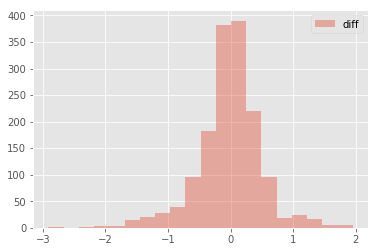

In [12]:
#use histogram to show the range of current_rating-overall_rating
plt.hist(appfilter['current_rating']-appfilter['overall_rating'],bins = 20, alpha = .4, label = 'diff')
plt.legend()
plt.show()

In [13]:
diff = appfilter['current_rating']-appfilter['overall_rating']

In [14]:
index2 = diff>=0.1#get the index of the difference larger than 0.1
index2b = diff<= -0.1#get the index of the difference smaller than -0.1

In [15]:
appinprove = appfilter.loc[index2]
appdecrease = appfilter.loc[index2b]

In [16]:
nvd = appinprove['new_version_desc']
nvdd = appdecrease['new_version_desc']

In [17]:
#compile documents
doc_complete = nvd.tolist()
doc_complete2 = nvdd.tolist()

In [18]:
#clean doc
import nltk
from nltk import corpus
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
stemmer = PorterStemmer().stem
tokenize = nltk.word_tokenize
stop = stopwords.words('english')+list(string.punctuation)+['we','new','fix','io','updat','improv','bug',
                                                            'app','featur','perform','ad',"\'s","--","us"
                                                            ,"minor","support","iphon","issu","add","enhanc",
                                                           "user","pleas","10","7","experi","thank",
                                                           "version","experi","screen","\'\'","2","6","icon",
                                                           "stabil","review","5","``"]
def stem(tokens,stemmer = PorterStemmer().stem):
    stemwords = [stemmer(w.lower()) for w in tokens if w not in stop]
    return [w for w in stemwords if w not in stop]
def lemmatize(text):
    return stem(tokenize(text))

In [19]:
doc_clean = [lemmatize(doc) for doc in doc_complete]
doc_clean2 = [lemmatize(doc) for doc in doc_complete2]

In [20]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)
dictionary2 = corpora.Dictionary(doc_clean2)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
doc_term_matrix2 = [dictionary2.doc2bow(doc) for doc in doc_clean2]

In [21]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)
ldamodel2 = Lda(doc_term_matrix2, num_topics=3, id2word = dictionary2, passes=50)

In [22]:
print(ldamodel.print_topics(num_topics=3, num_words=3))
print(ldamodel2.print_topics(num_topics=3, num_words=3))

[(0, u'0.008*"store" + 0.007*"make" + 0.007*"help"'), (1, u'0.006*"feedback" + 0.006*"thi" + 0.005*"crash"'), (2, u'0.010*"includ" + 0.008*"crash" + 0.006*"use"')]
[(0, u'0.007*"includ" + 0.007*"-bug" + 0.006*"locat"'), (1, u'0.008*"help" + 0.006*"play" + 0.006*"ipad"'), (2, u'0.006*"crash" + 0.006*"use" + 0.006*"share"')]


__Improved app__

In [185]:
index_interfac = []
for i in range(len(doc_clean)):
    if 'interfac' in doc_clean[i]:
        index_interfac.append(True)
    else:
        index_interfac.append(False)

In [187]:
nvd[index_interfac][1342]

u'Minor Interface Improvements'

In [188]:
index_feedback = []
for i in range(len(doc_clean)):
    if 'feedback' in doc_clean[i]:
        index_feedback.append(True)
    else:
        index_feedback.append(False)

In [190]:
nvd[index_feedback][193]

u"- New truth or dare cards - Fixed bugs & improved design If you have any feedback or suggestions, tweet us @truthdareapp! We'd love to hear from you."

In [192]:
index_store = []
for i in range(len(doc_clean)):
    if 'store' in doc_clean[i]:
        index_store.append(True)
    else:
        index_store.append(False)

In [241]:
nvd[index_store][1024]

u'- Bug fixes If you enjoy our apps, please leave us a review on the App Store. Reviews help us stay motivated to keep the updates coming. Thanks!'

__improved pattern__:

1.some improvements on interface

2.ask for feedbacks

3.ask for reviews on app store

__Worsen app__

In [214]:
index_ipad = []
for i in range(len(doc_clean2)):
    if 'ipad' in doc_clean2[i]:
        index_ipad.append(True)
    else:
        index_ipad.append(False)

In [220]:
nvdd[index_ipad][1373]

u'Holy Quran Arabic text with side by side English translation by Maulvi Sher Ali. Retina display support for iPhone 4+. Universal app with iPad support. Swipe slides the pages left and right accordingly.'

In [222]:
index_music = []
for i in range(len(doc_clean2)):
    if 'music' in doc_clean2[i]:
        index_music.append(True)
    else:
        index_music.append(False)

In [232]:
nvdd[index_music][2157]

u'- Introducing Music Share! After a quick over-the-air update for your headphones, you can stream music or audio with a friend between two Bose headphones at the same time. - Bug fixes and improvements'

In [234]:
index_card = []
for i in range(len(doc_clean2)):
    if 'card' in doc_clean2[i]:
        index_card.append(True)
    else:
        index_card.append(False)

In [239]:
nvdd[index_card][646]

u'Based on your feedback weve made some enhancements and fixed bugs to help improve your experience.  Added swipe gesture to access the digital card from account summary. (Digital Card is available on most CareCredit accounts.)  Improvements on performance and stability. *We have heard some CareCredit customers are experiencing issues logging into the CareCredit App. Please know that our team is aware and we are looking for the best solution. We will be making regular updates to the app to improve your experience.'

__woren pattern__:

1.add more features on ipad version

2.add more features related to music function

3.the apps are designed for cards

In [24]:
import pyLDAvis.gensim

In [25]:
pyLDAvis.enable_notebook()
dec_improv = pyLDAvis.gensim.prepare(ldamodel,doc_term_matrix, dictionary)
dec_decrea = pyLDAvis.gensim.prepare(ldamodel2,doc_term_matrix2, dictionary2)

In [26]:
dec_improv

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      37.259069        1       1 -0.100433  0.031973
1      36.078202        1       2  0.019949 -0.095557
2      26.662729        1       3  0.080484  0.063584, topic_info=     Category       Freq      Term      Total  loglift  logprob
term                                                           
2119  Default  19.000000      leav  19.000000  30.0000  30.0000
1619  Default  32.000000    includ  32.000000  29.0000  29.0000
98    Default  17.000000      work  17.000000  28.0000  28.0000
200   Default  14.000000    filter  14.000000  27.0000  27.0000
1979  Default  17.000000     email  17.000000  26.0000  26.0000
1637  Default  13.000000        ui  13.000000  25.0000  25.0000
1585  Default  20.000000       've  20.000000  24.0000  24.0000
195   Default   8.000000        -=   8.000000  23.0000  23.0000
1953  Default   8.000000        =-   8.000000  22.0000  22.0000
1646  Default  11.000000      chat  11.000000  21.0000  21.0000
139   Default  14.000000     order  14.000000  20.0000  20.0000
1277  Default  10.000000      sale  10.000000  19.0000  19.0000
1533  Default   7.000000     alert   7.000000  18.0000  18.0000
1515  Default  10.000000      pack  10.000000  17.0000  17.0000
234   Default  24.000000      rate  24.000000  16.0000  16.0000
447   Default  10.000000      -bug  10.000000  15.0000  15.0000
1816  Default  34.000000     crash  34.000000  14.0000  14.0000
1361  Default  31.000000     store  31.000000  13.0000  13.0000
2092  Default  18.000000      like  18.000000  12.0000  12.0000
86    Default  15.000000     notif  15.000000  11.0000  11.0000
590   Default   8.000000    appear   8.000000  10.0000  10.0000
1306  Default  12.000000    realli  12.000000   9.0000   9.0000
408   Default  10.000000   languag  10.000000   8.0000   8.0000
1532  Default  20.000000     optim  20.000000   7.0000   7.0000
1399  Default   8.000000      tool   8.000000   6.0000   6.0000
1148  Default   9.000000     small   9.000000   5.0000   5.0000
29    Default  20.000000     enjoy  20.000000   4.0000   4.0000
614   Default  24.000000      love  24.000000   3.0000   3.0000
1963  Default  22.000000      view  22.000000   2.0000   2.0000
1854  Default  15.000000    releas  15.000000   1.0000   1.0000
...       ...        ...       ...        ...      ...      ...
98     Topic3  11.210145      work  17.312169   0.8873  -5.1740
1585   Topic3  12.676074       've  20.303121   0.8508  -5.0511
1619   Topic3  18.857262    includ  32.411330   0.7803  -4.6539
574    Topic3   3.913395     level   5.221798   1.0335  -6.2264
1532   Topic3  11.626424     optim  20.390137   0.7601  -5.1376
1854   Topic3   9.461805    releas  15.847295   0.8062  -5.3436
227    Topic3   3.843326      sync   5.235166   1.0128  -6.2445
1479   Topic3   9.526430     devic  16.629250   0.7648  -5.3368
113    Topic3   3.794798    travel   5.238626   0.9995  -6.2572
2174   Topic3   6.054298   problem   9.796779   0.8406  -5.7901
1816   Topic3  15.307901     crash  34.218698   0.5175  -4.8625
2021   Topic3   7.915584   purchas  15.140732   0.6733  -5.5220
15     Topic3   7.335027     everi  13.633467   0.7020  -5.5982
1746   Topic3   7.557899    upgrad  14.369111   0.6794  -5.5682
94     Topic3   7.732787      word  15.180056   0.6474  -5.5454
1743   Topic3  12.691945       use  34.444242   0.3235  -5.0499
395    Topic3  10.431570      game  27.555794   0.3505  -5.2460
1356   Topic3   5.366432     stori   9.066511   0.7975  -5.9107
1165   Topic3   6.086348   section  11.363023   0.6976  -5.7848
1888   Topic3   7.918051      ipad  18.278175   0.4853  -5.5217
1731   Topic3   9.856023     chang  30.721049   0.1850  -5.3028
1869   Topic3   8.813726       set  26.864043   0.2074  -5.4145
143    Topic3   9.972850  feedback  40.894045  -0.0892  -5.2910
2099   Topic3   6.861630      page  16.789362   0.4271  -5.6649
1181   Topic3   7.187058    search  19.

In [27]:
pyLDAvis.save_html(dec_improv,'improved_apps.html')

In [28]:
dec_decrea

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      38.173809        1       1 -0.006833 -0.100485
0      31.467673        1       2 -0.087270  0.055921
1      30.358518        1       3  0.094103  0.044564, topic_info=     Category       Freq      Term      Total  loglift  logprob
term                                                           
1429  Default  12.000000      -bug  12.000000  30.0000  30.0000
762   Default  10.000000     beemo  10.000000  29.0000  29.0000
1765  Default  13.000000     locat  13.000000  28.0000  28.0000
1968  Default  13.000000   display  13.000000  27.0000  27.0000
1850  Default  10.000000   purchas  10.000000  26.0000  26.0000
401   Default  13.000000       plu  13.000000  25.0000  25.0000
476   Default   9.000000      push   9.000000  24.0000  24.0000
1923  Default  11.000000      leav  11.000000  23.0000  23.0000
1120  Default  20.000000     share  20.000000  22.0000  22.0000
529   Default   7.000000     gener   7.000000  21.0000  21.0000
1297  Default  13.000000         8  13.000000  20.0000  20.0000
429   Default  14.000000     music  14.000000  19.0000  19.0000
882   Default   8.000000    reward   8.000000  18.0000  18.0000
596   Default   7.000000   product   7.000000  17.0000  17.0000
1549  Default   7.000000     recip   7.000000  16.0000  16.0000
1563  Default  20.000000    access  20.000000  15.0000  15.0000
120   Default  13.000000    easier  13.000000  14.0000  14.0000
1345  Default   9.000000     point   9.000000  13.0000  13.0000
867   Default   6.000000  document   6.000000  12.0000  12.0000
1147  Default  22.000000      help  22.000000  11.0000  11.0000
1495  Default  13.000000        ui  13.000000  10.0000  10.0000
163   Default   6.000000   sunshin   6.000000   9.0000   9.0000
1677  Default  10.000000  categori  10.000000   8.0000   8.0000
919   Default   8.000000     manag   8.000000   7.0000   7.0000
850   Default   8.000000     sound   8.000000   6.0000   6.0000
1557  Default  16.000000  download  16.000000   5.0000   5.0000
1261  Default   9.000000      also   9.000000   4.0000   4.0000
464   Default  13.000000     notif  13.000000   3.0000   3.0000
789   Default   8.000000    variou   8.000000   2.0000   2.0000
1357  Default  11.000000      imag  11.000000   1.0000   1.0000
...       ...        ...       ...        ...      ...      ...
850    Topic3   6.602797     sound   8.773357   0.9079  -5.5690
1495   Topic3   9.317719        ui  13.082314   0.8527  -5.2246
1297   Topic3   8.907279         8  13.045209   0.8105  -5.2696
355    Topic3   6.685684     photo   9.498002   0.8410  -5.5565
52     Topic3   3.863370   preview   5.076188   0.9191  -6.1049
1147   Topic3  13.472458      help  22.798567   0.6660  -4.8558
829    Topic3   3.815271      mani   5.115003   0.8989  -6.1175
964    Topic3   3.813805  interfac   5.115075   0.8985  -6.1179
1911   Topic3   8.106250      page  13.124070   0.7103  -5.3638
1266   Topic3  11.091605      play  19.768525   0.6142  -5.0503
464    Topic3   8.212813     notif  13.818194   0.6718  -5.3508
1357   Topic3   6.915364      imag  11.052893   0.7231  -5.5227
509    Topic3   5.294814      team   7.978475   0.7821  -5.7898
1059   Topic3   7.706196    design  14.015659   0.5939  -5.4145
1723   Topic3   9.838121      ipad  21.983459   0.3881  -5.1702
958    Topic3   4.580019       log   6.600113   0.8267  -5.9348
1555   Topic3   8.426925     video  17.818639   0.4433  -5.3250
1967   Topic3   5.948757   problem  10.311981   0.6420  -5.6733
1386   Topic3   7.692522     optim  19.239398   0.2754  -5.4162
1563   Topic3   7.677414    access  20.960187   0.1878  -5.4182
1120   Topic3   7.485007     share  20.978591   0.1615  -5.4436
1050   Topic3   5.861122      list  11.767308   0.4951  -5.6881
1810   Topic3   6.344922     email  15.539820   0.2963  -5.6088
1475   Topic3   5.195458    custom   9.480487   0.5906  -5.8087
1589   Topic3   8.146350       use  32.

In [28]:
pyLDAvis.save_html(dec_decrea,'worsen_apps.html')